<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Evolving Maxwell's Equations with Toriodal Dipole Field Initial Data, in Flat Spacetime and Cartesian Coordinates - System I

## Following the work of [Knapp, Walker & Baumgarte (2002)](https://arxiv.org/abs/gr-qc/0201051), we numerically implement two versions of Maxwell’s equations, and find that their distinct numerical properties reflect those found in solving the ADM equations (System I) and the BSSN (System II) equations, namely the presence of static constraint violating nodes in System I and the propagation of these nodes in System II. 

## Author: Terrence Pierre Jacques and Zachariah Etienne
### Formatting improvements courtesy Brandon Clark

**Notebook Status:** <font color = green><b> Validated </b></font>

**Validation Notes:** This module has been validated to exhibit convergence to the exact solution for the electric field $E^i$ and vector potential $A^i$ at the expected order, *after a short numerical evolution of the initial data* (see [plots at bottom](#convergence)).

### NRPy+ Source Code for this module: 
* [Maxwell/InitialData.py](../edit/Maxwell/InitialData.py); [\[**tutorial**\]](Tutorial-VacuumMaxwell_InitialData.ipynb): Purely toriodal dipole field initial data; sets all electromagnetic variables in the Cartesian basis
* [Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py](../edit/Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py); [\[**tutorial**\]](Tutorial-VacuumMaxwell_Cartesian_RHSs.ipynb): Generates the right-hand sides for Maxwell's equations in Cartesian coordinates

## Introduction:
Here we use NRPy+ to generate the C source code necessary to set up initial data for a purely toriodal dipole field, as defined in [Knapp, Walker & Baumgarte (2002)](https://arxiv.org/abs/gr-qc/0201051). We then evolve the RHSs of Maxwell's equations using the [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on an [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%H%93Kutta_methods) (RK4 is chosen below, but multiple options exist). 

The entire algorithm is outlined as follows, with links to the relevant NRPy+ tutorial notebooks listed at each step:

1. Allocate memory for gridfunctions, including temporary storage for the Method of Lines time integration
    * [**NRPy+ tutorial on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).
1. Set gridfunction values to initial data 
    * [**NRPy+ tutorial on purely toriodal dipole field initial data**](Tutorial-VacuumMaxwell_InitialData.ipynb)
1. Next, integrate the initial data forward in time using the Method of Lines coupled to a Runge-Kutta explicit timestepping algorithm:
    1. At the start of each iteration in time, output constraint violation 
        * [**NRPy+ tutorial on Maxwell's equations constraints**](Tutorial-VacuumMaxwell_Cartesian_RHSs.ipynb).
    1. At each RK time substep, do the following:
        1. Evaluate RHS expressions 
            * [**NRPy+ tutorial on Maxwell's equations right-hand sides**](Tutorial-VacuumMaxwell_Cartesian_RHSs.ipynb)
        1. Apply Sommerfeld boundary conditions in Cartesian coordinates
            * [**NRPy+ tutorial on setting up Sommerfeld boundary conditions**](Tutorial-SommerfeldBoundaryCondition.ipynb)        
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initialize): Set core parameters
    1. [Steb 1.a](#runtime): Set runtime parameters
    1. [Step 1.b](#initializenrpy): Set core NRPy+ parameters for numerical grids and reference metric
    1. [Step 1.c](#cfl): Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%H%93Friedrichs%E2%H%93Lewy_condition&oldid=HL30673)-limited timestep
1. [Step 2](#mw): Generate symbolic expressions and output C code for evolving Maxwell's equations
    1. [Step 2.a](#mwid): Generate symbolic expressions for toroidal dipole field initial data
    1. [Step 2.b](#mwevol): Generate symbolic expressions for evolution equations
    1. [Step 2.c](#mwcon): Generate symbolic expressions for constraint equations
    1. [Step 2.d](#mwccode): Output C codes for initial data and evolution equations
    1. [Step 2.e](#mwccode_con): Output C code for constraint equations
    1. [Step 2.f](#cparams_rfm_and_domainsize): Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h`
1. [Step 3](#bc_functs): Set up Sommerfeld boundary condition functions for Cartesian coordinate system
1. [Step 4](#mainc): `Maxwell_Playground.c`: The Main C Code
1. [Step 5](#compileexec): Compile generated C codes & perform simulation of the propagating toriodal electromagnetic field
1. [Step 6](#convergence): Plot the numerical error, and confirm that it converges to zero with increasing numerical resolution (sampling)
1. [Step 7](#div_e): Comparison of Divergence Constrain Violation
1. [Step 8](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initialize'></a>

# Step 1: Set core parameters  \[Back to [top](#toc)\]
$$\label{initialize}$$

<a id='runtime'></a>

## Step 1.a: Set runtime parameters \[Back to [top](#toc)\]
$$\label{runtime}$$

Replicating the results of [Knapp, Walker & Baumgarte (2002)](https://arxiv.org/abs/gr-qc/0201051) is quite expensive, so we give the option to set runtime parameters for shorter runs.

In the cell below we define the runtime parameters to be read by our [C code](#mainc) later. Specifically, we can default to a quick output with a coarser resolution for our second run as compared to that of [Knapp, Walker & Baumgarte (2002)](https://arxiv.org/abs/gr-qc/0201051) ($N_x = N_y = N_z = 80$ instead of $N_x = N_y = N_z = 128$). 

In [1]:
replicate_paper_results = False

Nxx_L = '64'
if replicate_paper_results == False:
    t_final = '1.25'
    Nxx_H = '80'
else:
    t_final = '100.0'
    Nxx_H = '128'


<a id='initializenrpy'></a>

## Step 1.b: Set core NRPy+ parameters for numerical grids and reference metric  \[Back to [top](#toc)\]
$$\label{initializenrpy}$$

Set core NRPy+ parameters for numerical grids and reference metric

In [2]:
# Step P1: Import needed NRPy+ core modules:
from outputC import lhrh,outCfunction # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions, benchmarking

# Step P2: Create C code output directory:
Ccodesdir = os.path.join("MaxwellEvolCart_Playground_Ccodes/")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
# !rm -r ScalarWaveCurvilinear_Playground_Ccodes
shutil.rmtree(Ccodesdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesdir,"output/")
cmd.mkdir(outdir)

# Step 1: Set the spatial dimension parameter
#         to three (BSSN is a 3+1 decomposition
#         of Einstein's equations), and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 2: Set some core parameters, including CoordSystem MoL BoundaryCondition timestepping algorithm,
#                                 FD order, floating point precision, and CFL factor:
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "Cartesian"

# Step  2.a: Set boundary conditions
# Current choices are QuadraticExtrapolation (quadratic polynomial extrapolation) or Sommerfeld
BoundaryCondition = "Sommerfeld"

# Step 2.b: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.

# domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
domain_size     = 4.0 # Needed for all coordinate systems.

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05 # If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 0.5 # If SymTP chosen

# Step 2.c: Set the order of spatial and temporal derivatives;
#           the core data type, and the CFL factor.
# RK_method choices include: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
FD_order  = 4        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.
default_CFL_FACTOR= 0.5      # (GETS OVERWRITTEN WHEN EXECUTED.) In pure axisymmetry (symmetry_axes = 2 below) 1.0 works fine. Otherwise 0.5 or lower.

# Step 3: Generate Runge-Kutta-based (RK-based) timestepping code.
#       3.A: Evaluate RHSs (RHS_string)
#       3.B: Apply boundary conditions (RHS_string)
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_order  = Butcher_dict[RK_method][1]
cmd.mkdir(os.path.join(Ccodesdir,"MoLtimestepping/"))

RHS_string = "rhs_eval(&rfmstruct, &params, RK_INPUT_GFS, RK_OUTPUT_GFS);"

if BoundaryCondition == "QuadraticExtrapolation":
    # Extrapolation BCs are applied to the evolved gridfunctions themselves after the MoL update
    post_RHS_string = "apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, RK_OUTPUT_GFS);"
elif BoundaryCondition == "Sommerfeld":
    # Sommerfeld BCs are applied to the gridfunction RHSs directly
    RHS_string += "\n apply_bcs_sommerfeld(&params, xx, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, RK_INPUT_GFS, RK_OUTPUT_GFS);"
    post_RHS_string = ""
else:
    print("Invalid choice of boundary condition")
    sys.exit(1)

MoL.MoL_C_Code_Generation(RK_method, RHS_string = RHS_string, post_RHS_string = post_RHS_string,
                          outdir = os.path.join(Ccodesdir,"MoLtimestepping/"))

# Step 4: Set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)

# Step 5: Set the finite differencing order.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",FD_order)

cmd.mkdir(os.path.join(Ccodesdir,"rfm_files/"))
par.set_parval_from_str("reference_metric::enable_rfm_precompute","True")
par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(Ccodesdir,"rfm_files/"))
rfm.reference_metric()
# Step 6: Now that we are finished with all the rfm hatted
#           quantities, let's restore them to their closed-
#           form expressions.
par.set_parval_from_str("reference_metric::enable_rfm_precompute","False") # Reset to False to disable rfm_precompute.
rfm.ref_metric__hatted_quantities()

# Step 7: Copy SIMD/SIMD_intrinsics.h to $Ccodesdir/SIMD/SIMD_intrinsics.h
cmd.mkdir(os.path.join(Ccodesdir,"SIMD"))
shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesdir,"SIMD/"))

'MaxwellEvolCart_Playground_Ccodes/SIMD/SIMD_intrinsics.h'

<a id='cfl'></a>

## Step 1.c: Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%H%93Friedrichs%E2%H%93Lewy_condition&oldid=HL30673)-limited timestep \[Back to [top](#toc)\]
$$\label{cfl}$$

In order for our explicit-timestepping numerical solution to Maxwell's equations to be stable, it must satisfy the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%H%93Friedrichs%E2%H%93Lewy_condition&oldid=HL30673) condition:
$$
\Delta t \le \frac{\min(ds_i)}{c},
$$
where $c$ is the wavespeed, and
$$ds_i = h_i \Delta x^i$$ 
is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction:

In [3]:
# Output the find_timestep() function to a C file.
rfm.out_timestep_func_to_file(os.path.join(Ccodesdir,"find_timestep.h"))

<a id='mw'></a>

# Step 2: Generate symbolic expressions and output C code for evolving Maxwell's equations \[Back to [top](#toc)\]
$$\label{mw}$$

Here we read in the symbolic expressions from the NRPy+ [InitialData](../edit/Maxwell/InitialData.py) and [Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py](../edit/Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py) modules to define the initial data, evolution equations, and constraint equations.

<a id='mwid'></a>

## Step 2.a: Generate symbolic expressions for toroidal dipole field initial data \[Back to [top](#toc)\]
$$\label{mwid}$$



Here we use the NRPy+ [InitialData](../edit/Maxwell/InitialData.py) module, described in [this tutorial](Tutorial-VacuumMaxwell_InitialData.ipynb), to write initial data to the grid functions for both systems.

In [4]:
import Maxwell.InitialData as mwid

def Maxwell_ID__generate_Ccode():

# Set which system to use, which are defined in Maxwell/InitialData.py
#  Both systems have the same initial data

    par.set_parval_from_str("Maxwell.InitialData::System_to_use","System_II")

    mwid.InitialData()

    Maxwell_ID_SymbExpressions = [\
                     lhrh(lhs="*AIU0_exact",rhs=mwid.AidU[0]),\
                     lhrh(lhs="*AIU1_exact",rhs=mwid.AidU[1]),\
                     lhrh(lhs="*AIU2_exact",rhs=mwid.AidU[2]),\
                     lhrh(lhs="*EIU0_exact",rhs=mwid.EidU[0]),\
                     lhrh(lhs="*EIU1_exact",rhs=mwid.EidU[1]),\
                     lhrh(lhs="*EIU2_exact",rhs=mwid.EidU[2]),\
                     lhrh(lhs="*PSYI_exact",rhs=mwid.psi_ID),\
                     lhrh(lhs="*AIIU0_exact",rhs=mwid.AidU[0]),\
                     lhrh(lhs="*AIIU1_exact",rhs=mwid.AidU[1]),\
                     lhrh(lhs="*AIIU2_exact",rhs=mwid.AidU[2]),\
                     lhrh(lhs="*EIIU0_exact",rhs=mwid.EidU[0]),\
                     lhrh(lhs="*EIIU1_exact",rhs=mwid.EidU[1]),\
                     lhrh(lhs="*EIIU2_exact",rhs=mwid.EidU[2]),\
                     lhrh(lhs="*PSYII_exact",rhs=mwid.psi_ID),\
                     lhrh(lhs="*GAMMAII_exact",rhs=mwid.Gamma_ID)]

    Maxwell_ID_CcodeKernel = fin.FD_outputC("returnstring",
                            Maxwell_ID_SymbExpressions)
    return Maxwell_ID_CcodeKernel


<a id='mwevol'></a>

## Step 2.b: Generate symbolic expressions for evolution equations \[Back to [top](#toc)\]
$$\label{mwevol}$$

Here we use the NRPy+ [Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py](../edit/Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py) module, described in [this tutorial](Tutorial-VacuumMaxwell_Cartesian_RHSs.ipynb), to ascribe the evolution equations to the grid functions.

In [5]:
import Maxwell.VacuumMaxwell_Flat_Evol_Cartesian as rhs

def Maxwell_RHSs__generate_symbolic_expressions_SystemI():
    ######################################
    # START: GENERATE SYMBOLIC EXPRESSIONS

    # Set which system to use, which are defined in Maxwell/InitialData.py
    par.set_parval_from_str("Maxwell.InitialData::System_to_use","System_I")

    rhs.VacuumMaxwellRHSs()

    # END: GENERATE SYMBOLIC EXPRESSIONS
    ######################################

    # System I: _AIU, _EIU, _psyI are not manipulated explicitly
    _AIU = ixp.register_gridfunctions_for_single_rank1("EVOL","AIU")
    _EIU = ixp.register_gridfunctions_for_single_rank1("EVOL","EIU")
    _psyI = gri.register_gridfunctions("EVOL","psyI")
    C_SystemI = rhs.C

    Maxwell_RHSs_SymbExpressions_SystemI = [\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","AIU0"),rhs=rhs.ArhsU[0]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","AIU1"),rhs=rhs.ArhsU[1]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","AIU2"),rhs=rhs.ArhsU[2]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","EIU0"),rhs=rhs.ErhsU[0]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","EIU1"),rhs=rhs.ErhsU[1]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","EIU2"),rhs=rhs.ErhsU[2]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","psyI"),rhs=rhs.psi_rhs)]

    # Avoid re-registering GFs later
    del gri.glb_gridfcs_list[:8]

    return [Maxwell_RHSs_SymbExpressions_SystemI, C_SystemI]

def Maxwell_RHSs__generate_symbolic_expressions_SystemII():
    ######################################
    # START: GENERATE SYMBOLIC EXPRESSIONS

    # Set which system to use, which are defined in Maxwell/InitialData.py
    par.set_parval_from_str("Maxwell.InitialData::System_to_use","System_II")

    rhs.VacuumMaxwellRHSs()

   # END: GENERATE SYMBOLIC EXPRESSIONS
    ######################################

    # Register gridfunctions so they can be written to by NRPy.
    # System II: _AIIU, _EIIU, _psyII and _GammaII are not manipulated explicitly
    _AIIU = ixp.register_gridfunctions_for_single_rank1("EVOL","AIIU")
    _EIIU = ixp.register_gridfunctions_for_single_rank1("EVOL","EIIU")
    _psyII = gri.register_gridfunctions("EVOL","psyII")
    _GammaII = gri.register_gridfunctions("EVOL","GammaII")
    C_SystemII = rhs.C
    G_SystemII = rhs.G

    Maxwell_RHSs_SymbExpressions_SystemII =  [\
                      lhrh(lhs=gri.gfaccess("rhs_gfs","AIIU0"),rhs=rhs.ArhsU[0]),\
                      lhrh(lhs=gri.gfaccess("rhs_gfs","AIIU1"),rhs=rhs.ArhsU[1]),\
                      lhrh(lhs=gri.gfaccess("rhs_gfs","AIIU2"),rhs=rhs.ArhsU[2]),\
                      lhrh(lhs=gri.gfaccess("rhs_gfs","EIIU0"),rhs=rhs.ErhsU[0]),\
                      lhrh(lhs=gri.gfaccess("rhs_gfs","EIIU1"),rhs=rhs.ErhsU[1]),\
                      lhrh(lhs=gri.gfaccess("rhs_gfs","EIIU2"),rhs=rhs.ErhsU[2]),\
                      lhrh(lhs=gri.gfaccess("rhs_gfs","psyII"),rhs=rhs.psi_rhs),\
                      lhrh(lhs=gri.gfaccess("rhs_gfs","GammaII"),rhs=rhs.Gamma_rhs)]

    return [Maxwell_RHSs_SymbExpressions_SystemII, C_SystemII, G_SystemII]

def Maxwell_RHSs__generate_Ccode(all_RHSs_exprs_list_SystemI, all_RHSs_exprs_list_SystemII):
    Maxwell_RHSs_SymbExpressions_SystemI  = all_RHSs_exprs_list_SystemI
    Maxwell_RHSs_SymbExpressions_SystemII = all_RHSs_exprs_list_SystemII

    Maxwell_RHSs_string_SystemI = fin.FD_outputC("returnstring",Maxwell_RHSs_SymbExpressions_SystemI,
                                      params="enable_SIMD=True").replace("AU","AIU")\
                                                                .replace("EU","EIU")\
                                                                .replace("PSI","PSYI")\
                                                                .replace("psi","psyI")

    Maxwell_RHSs_string_SystemII = fin.FD_outputC("returnstring",Maxwell_RHSs_SymbExpressions_SystemII,
                                      params="enable_SIMD=True").replace("AU","AIIU")\
                                                                .replace("EU","EIIU")\
                                                                .replace("psi","psyII")\
                                                                .replace("PSI","PSYII")\
                                                                .replace("GAMMAGF","GAMMAIIGF")\
                                                                .replace("Gamma","GammaII")

    return Maxwell_RHSs_string_SystemI + Maxwell_RHSs_string_SystemII

<a id='mwcon'></a>

## Step 2.c: Generate symbolic expressions for constraint equations \[Back to [top](#toc)\]
$$\label{mwcon}$$

We now use the NRPy+ [Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py](../edit/Maxwell/VacuumMaxwell_Flat_Evol_Cartesian.py) module, described in [this tutorial](Tutorial-VacuumMaxwell_Cartesian_RHSs.ipynb), to ascribe the constraint equations.

In [6]:
def Maxwell_constraints__generate_symbolic_expressions_and_C_code(C_SystemI,
                                                                  C_SystemII,
                                                                  G_SystemII):
# _CI, _CII and _GII are not manipulated explicitly
    _CI  = gri.register_gridfunctions("AUX", "CI")
    _CII = gri.register_gridfunctions("AUX", "CII")
    _GII = gri.register_gridfunctions("AUX", "GII")

    Constraints_string_SystemI = fin.FD_outputC("returnstring",
                                    [lhrh(lhs=gri.gfaccess("aux_gfs", "CI"),  rhs=C_SystemI)],
                                    params="outCverbose=False").replace("AU","AIU")\
                                                               .replace("EU","EIU")\
                                                               .replace("PSI","PSYI")\
                                                               .replace("psi","psyI")

    Constraints_string_SystemII = fin.FD_outputC("returnstring",
                                    [lhrh(lhs=gri.gfaccess("aux_gfs", "CII"), rhs=C_SystemII),
                                     lhrh(lhs=gri.gfaccess("aux_gfs", "GII"),    rhs=G_SystemII)],
                                    params="outCverbose=False").replace("AU","AIIU")\
                                                               .replace("EU","EIIU")\
                                                               .replace("psi","psyII")\
                                                               .replace("PSI","PSYII")\
                                                               .replace("GAMMAGF","GAMMAIIGF")\
                                                               .replace("Gamma","GammaII")

    return Constraints_string_SystemI + Constraints_string_SystemII


<a id='mwccode'></a>

## Step 2.d: Output C codes for initial data and evolution equations \[Back to [top](#toc)\]
$$\label{mwccode}$$

Next we write the C codes for the initial data and evolution equations to files, to be used later by our main C code.

In [7]:
# Generate all needed C functions
Part_P1_body = Maxwell_ID__generate_Ccode()
desc="Declare the function for the exact solution at a single point. time==0 corresponds to the initial data."
name="exact_solution_single_point"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="const REAL xx0,const REAL xx1,const REAL xx2,const paramstruct *restrict params,\
                                        REAL *EIU0_exact,  \
                                        REAL *EIU1_exact,  \
                                        REAL *EIU2_exact,  \
                                        REAL *AIU0_exact,  \
                                        REAL *AIU1_exact,  \
                                        REAL *AIU2_exact,  \
                                        REAL *PSYI_exact, \
                                        REAL *EIIU0_exact, \
                                        REAL *EIIU1_exact, \
                                        REAL *EIIU2_exact, \
                                        REAL *AIIU0_exact, \
                                        REAL *AIIU1_exact, \
                                        REAL *AIIU2_exact, \
                                        REAL *PSYII_exact,\
                                        REAL *GAMMAII_exact",
    body     = Part_P1_body,
    loopopts = "")

desc="Declare the function for the exact solution at all points. time==0 corresponds to the initial data."
name="exact_solution_all_points"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict in_gfs",
    body     ="""
REAL xCart[3]; xx_to_Cart(params,xx, i0,i1,i2, xCart);
REAL xx0 = xCart[0]; REAL xx1 = xCart[1]; REAL xx2 = xCart[2];
exact_solution_single_point(xx0,xx1,xx2,params,&in_gfs[IDX4S(EIU0GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(EIU1GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(EIU2GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(AIU0GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(AIU1GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(AIU2GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(PSYIGF,i0,i1,i2)],
                                               &in_gfs[IDX4S(EIIU0GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(EIIU1GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(EIIU2GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(AIIU0GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(AIIU1GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(AIIU2GF,i0,i1,i2)],
                                               &in_gfs[IDX4S(PSYIIGF,i0,i1,i2)],
                                               &in_gfs[IDX4S(GAMMAIIGF,i0,i1,i2)]);""",
    loopopts = "AllPoints")


SystemI_exprs  = Maxwell_RHSs__generate_symbolic_expressions_SystemI()
SystemII_exprs = Maxwell_RHSs__generate_symbolic_expressions_SystemII()

Part_P2_body = Maxwell_RHSs__generate_Ccode(SystemI_exprs[0], SystemII_exprs[0])

desc="Declare the function to evaluate the RHSs of Maxwell's equations"
name="rhs_eval"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   ="""rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                 const REAL *restrict in_gfs, REAL *restrict rhs_gfs""",
    body     =Part_P2_body,
    loopopts = "InteriorPoints,enable_SIMD,enable_rfm_precompute")

Currently using System_II initial data
Output C function exact_solution_single_point() to file MaxwellEvolCart_Playground_Ccodes/exact_solution_single_point.h
Output C function exact_solution_all_points() to file MaxwellEvolCart_Playground_Ccodes/exact_solution_all_points.h
Currently using System_I RHSs 

Currently using System_II RHSs 

Output C function rhs_eval() to file MaxwellEvolCart_Playground_Ccodes/rhs_eval.h


<a id='mwccode_con'></a>

## Step 2.e: Output C code for constraint equations \[Back to [top](#toc)\]
$$\label{mwccode_con}$$

Finally output the C code for evaluating the constraints, described in [this tutorial](Tutorial-VacuumMaxwell_Cartesian_RHSs.ipynb). In the absence of numerical error, the constraints should evaluate to zero, but due to numerical (typically truncation and roundoff) error they do not. We will therefore measure constraint violations to gauge the accuracy of our simulation, and ultimately determine whether errors are dominated by numerical finite differencing (truncation) error as expected.

In [8]:
# Set up the C function for the constraint equations
Part_P3_body = Maxwell_constraints__generate_symbolic_expressions_and_C_code(SystemI_exprs[1],
                                                              SystemII_exprs[1],
                                                              SystemII_exprs[2])

desc="Evaluate the constraint violations"
name="Constraints"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), desc=desc, name=name,
    params   = """rfm_struct *restrict rfmstruct,const paramstruct *restrict params,
                  REAL *restrict in_gfs, REAL *restrict aux_gfs""",
    body     = Part_P3_body,
    loopopts = "InteriorPoints,enable_rfm_precompute")

Output C function Constraints() to file MaxwellEvolCart_Playground_Ccodes/Constraints.h


<a id='cparams_rfm_and_domainsize'></a>

## Step 2.f: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Based on declared NRPy+ Cparameters, first we generate `declare_Cparameters_struct.h`, `set_Cparameters_default.h`, and `set_Cparameters[-SIMD].h`.

Then we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [9]:
# Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

# Set free_parameters.h
with open(os.path.join(Ccodesdir,"free_parameters.h"),"w") as file:
    file.write("""
// Set free-parameter values.
params.time = 0.0; // Initial simulation time time corresponds to exact solution at time=0.
params.amp = 1.0;
params.lam = 1.0;
params.wavespeed = 1.0;\n""")

# Append to $Ccodesdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesdir,"free_parameters.h"),
                                        domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)

# Generate set_Nxx_dxx_invdx_params__and__xx.h:
rfm.set_Nxx_dxx_invdx_params__and__xx_h(Ccodesdir, grid_centering="cell")

# Generate xx_to_Cart.h, which contains xx_to_Cart() for
#  (the mapping from xx->Cartesian) for the chosen CoordSystem:
rfm.xx_to_Cart_h("xx_to_Cart","./set_Cparameters.h",os.path.join(Ccodesdir,"xx_to_Cart.h"))

# Step 3.d.v: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

<a id='bc_functs'></a>

# Step 3: Set up Sommerfeld boundary condition for Cartesian coordinate system \[Back to [top](#toc)\]
$$\label{bc_functs}$$

Next we output the C code necessary to implement the Sommerfeld boundary condition in Cartesian coordinates, [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-SommerfeldBoundaryCondition.ipynb)

In [10]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions(os.path.join(Ccodesdir,"boundary_conditions/"),
                                   Cparamspath=os.path.join("../"),
                                   BoundaryCondition=BoundaryCondition)

if BoundaryCondition == "Sommerfeld":
    bcs = cbcs.sommerfeld_boundary_condition_class(fd_order=2,
                                             vars_radial_falloff_power_default=3,
                                             vars_speed_default=1.,
                                             vars_at_inf_default=0.)
    bcs.write_sommerfeld_file(Ccodesdir)

Wrote to file "MaxwellEvolCart_Playground_Ccodes/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved parity: ( AIIU0:1, AIIU1:2, AIIU2:3, AIU0:1, AIU1:2, AIU2:3, AU0:1,
    AU1:2, AU2:3, EIIU0:1, EIIU1:2, EIIU2:3, EIU0:1, EIU1:2, EIU2:3, EU0:1,
    EU1:2, EU2:3, Gamma:0, GammaII:0, psi:0, psyI:0, psyII:0 )
Auxiliary parity: ( CI:0, CII:0, DivE:0, G:0, GII:0 )

Wrote to file "MaxwellEvolCart_Playground_Ccodes/boundary_conditions/EigenCoord_Cart_to_xx.h"

Successfully generated Sommerfeld boundary condition C code


<a id='mainc'></a>

# Step 4: `Maxwell_Playground.c`: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$

In [11]:
# Part P0: Define REAL, set the number of ghost cells NGHOSTS (from NRPy+'s FD_CENTDERIVS_ORDER),
#          and set the CFL_FACTOR (which can be overwritten at the command line)

with open(os.path.join(Ccodesdir,"Maxwell_Playground_REAL__NGHOSTS__CFL_FACTOR.h"), "w") as file:
    file.write("""
// Part P0.a: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
#define NGHOSTS """+str(int(FD_order/2)+1)+"""
// Part P0.b: Set the numerical precision (REAL) to double, ensuring all floating point
//            numbers are stored to at least ~16 significant digits
#define REAL """+REAL+"""
// Part P0.c: Set the CFL Factor. Can be overwritten at command line.
REAL CFL_FACTOR = """+str(default_CFL_FACTOR)+";")

In [12]:
%%writefile $Ccodesdir/Maxwell_Playground.c

// Step P0: Define REAL and NGHOSTS; and declare CFL_FACTOR. This header is generated in NRPy+.
#include "Maxwell_Playground_REAL__NGHOSTS__CFL_FACTOR.h"

#include "rfm_files/rfm_struct__declare.h"

#include "declare_Cparameters_struct.h"

// All SIMD intrinsics used in SIMD-enabled C code loops are defined here:
#include "SIMD/SIMD_intrinsics.h"

// Step P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"
#include "stdint.h" // Needed for Windows GCC 6.x compatibility
#ifndef M_PI
#define M_PI 3.141592653589793238462L3383279502884L
#endif
#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif

// Step P2: Declare the IDX4S(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i"
//           (all other indices held to a fixed value) are consecutive in memory, where
//           consecutive values of "j" (fixing all other indices) are separated by
//           Nxx_plus_2NGHOSTS0 elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1 in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define IDX4ptS(g,idx) ( (idx) + (Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) * (g) )
#define IDX3S(i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) ) ) )
#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") \
  for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)

// Step P3: Set UUGF and VVGF macros, as well as xx_to_Cart()
#include "boundary_conditions/gridfunction_defines.h"

// Step P4: Set xx_to_Cart(const paramstruct *restrict params,
//                     REAL *restrict xx[3],
//                     const int i0,const int i1,const int i2,
//                     REAL xCart[3]),
//           which maps xx->Cartesian via
//    {xx[0][i0],xx[1][i1],xx[2][i2]}->{xCart[0],xCart[1],xCart[2]}
#include "xx_to_Cart.h"

// Step P5: Defines set_Nxx_dxx_invdx_params__and__xx(const int EigenCoord, const int Nxx[3],
//                                       paramstruct *restrict params, REAL *restrict xx[3]),
//          which sets params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for
//          the chosen Eigen-CoordSystem if EigenCoord==1, or
//          CoordSystem if EigenCoord==0.
#include "set_Nxx_dxx_invdx_params__and__xx.h"

// Step P6: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "boundary_conditions/CurviBC_include_Cfunctions.h"

// Step P9: Find the CFL-constrained timestep
#include "find_timestep.h"

// Part P8: Declare the function for the exact solution at a single point. time==0 corresponds to the initial data.
#include "exact_solution_single_point.h"

// Part P9: Declare the function for the exact solution at all points. time==0 corresponds to the initial data.
#include "exact_solution_all_points.h"

// Step P11: Declare function for evaluating divergence constraint (diagnostic)
#include "Constraints.h"

// Step P12: Declare rhs_eval function, which evaluates the RHSs of Maxwells equations
#include "rhs_eval.h"

// Function to calculate relative error
REAL relative_error(REAL num, REAL exact) {
    REAL E_rel = log10( fabs(  (num - exact)/(exact)  ) );
    return E_rel;
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up initial data to an exact solution
// Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
// Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
//         Lines timestepping algorithm, and output periodic simulation diagnostics
// Step 3.a: Output constraint violation
// Step 3.b: Output 1D data file periodically, for visualization
// Step 3.c: Step forward one timestep (t -> t+dt) in time using
//           chosen RK-like MoL timestepping algorithm
// Step 3.d: Progress indicator printing to stderr
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    paramstruct params;
#include "set_Cparameters_default.h"

    // Step 0a: Read command-line input, error out if nonconformant
    if( atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./Maxwell_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }

    CFL_FACTOR = strtod(argv[4],NULL);
    if(CFL_FACTOR > 0.5 && atoi(argv[3])!=2) {
        fprintf(stderr,"WARNING: CFL_FACTOR was set to %e, which is > 0.5.\n",CFL_FACTOR);
        fprintf(stderr,"         This will generally only be stable if the simulation is purely axisymmetric\n");
        fprintf(stderr,"         However, Nx2 was set to %d>2, which implies a non-axisymmetric simulation\n",atoi(argv[3]));
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }

    // Step 0c: Set free parameters, overwriting Cparameters defaults
    //          by hand or with command-line input, as desired.
#include "free_parameters.h"

   // Step 0d: Uniform coordinate grids are stored to *xx[3]
    REAL *xx[3];
    // Step 0d.i: Set bcstruct
    bc_struct bcstruct;
    {
        int EigenCoord = 1;
        // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
        //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
        //             chosen Eigen-CoordSystem.
        set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);
        // Step 0d.iii: Set Nxx_plus_2NGHOSTS_tot
#include "set_Cparameters-nopointer.h"
        const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
        // Step 0e: Find ghostzone mappings; set up bcstruct
#include "boundary_conditions/driver_bcstruct.h"
        // Step 0e.i: Free allocated space for xx[][] array
        for(int i=0;i<3;i++) free(xx[i]);
    }

    // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    int EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

    // Step 0g: Set all C parameters "blah" for params.blah, including
    //          Nxx_plus_2NGHOSTS0 = params.Nxx_plus_2NGHOSTS0, etc.
#include "set_Cparameters-nopointer.h"
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

    // Step 0h: Time coordinate parameters
    const REAL t_final = atof(argv[5]);

    // Step 0i: Set timestep based on smallest proper distance between gridpoints and CFL factor
    REAL dt = find_timestep(&params, xx);
    //fprintf(stderr,"# Timestep set to = %e\n",(double)dt);
    int N_final = (int)(t_final / dt + 0.5); // The number of points in time.
                                             // Add 0.5 to account for C rounding down
                                             // typecasts to integers.

    // Step 0j: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
    //              This is a limitation of the RK method. You are always welcome to declare & allocate
    //              additional gridfunctions by hand.
    if(NUM_AUX_GFS > NUM_EVOL_GFS) {
        fprintf(stderr,"Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
        fprintf(stderr,"       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
        exit(1);
    }

    // Step 0k: Allocate memory for gridfunctions
#include "MoLtimestepping/RK_Allocate_Memory.h"
    REAL *restrict y_0_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);


    // Step 0l: Set up precomputed reference metric arrays
    // Step 0l.i: Allocate space for precomputed reference metric arrays.
#include "rfm_files/rfm_struct__malloc.h"

    // Step 0l.ii: Define precomputed reference metric arrays.
    {
    #include "set_Cparameters-nopointer.h"
    #include "rfm_files/rfm_struct__define.h"
    }

    // Step 1: Set up initial data to be exact solution at time=0:
    params.time = 0.0;
    exact_solution_all_points(&params, xx, y_n_gfs);

    // Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
#ifdef __linux__ // Use high-precision timer in Linux.
    struct timespec start, end;
    clock_gettime(CLOCK_REALTIME, &start);
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
    // http://www.cplusplus.com/reference/ctime/time/
    time_t start_timer,end_timer;
    time(&start_timer); // Resolution of one second...
#endif

    // Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
    //         Lines timestepping algorithm, and output periodic simulation diagnostics
    for(int n=0;n<=N_final+1;n++) { // Main loop to progress forward in time.

        // Set Constraints to NaN in the grid interior, to ensure there are no memory issues
        LOOP_REGION(NGHOSTS,NGHOSTS+Nxx0,
                    NGHOSTS,NGHOSTS+Nxx1,
                    NGHOSTS,NGHOSTS+Nxx2) {
                    const int idx = IDX3S(i0,i1,i2);
                    diagnostic_output_gfs[IDX4ptS(CIGF,idx)]  = 0.0/0.0;
                    diagnostic_output_gfs[IDX4ptS(CIIGF,idx)] = 0.0/0.0;
                    diagnostic_output_gfs[IDX4ptS(GIIGF,idx)] = 0.0/0.0;
            }

        // Step 3.a: Output constraint violation
        params.time = ((REAL)n)*dt;
        // Evaluate Divergence constraint violation
        Constraints(&rfmstruct, &params, y_n_gfs, diagnostic_output_gfs);
        // log_L2_Norm = log10( sqrt[Integral( [numerical - exact]^2 * dV)] )
        REAL L2Norm_sum_CI = 0.;
        REAL L2Norm_sum_CII = 0.;
        int count = 0;
        LOOP_REGION(NGHOSTS,NGHOSTS+Nxx0,
                    NGHOSTS,NGHOSTS+Nxx1,
                    NGHOSTS,NGHOSTS+Nxx2) {
            const int idx = IDX3S(i0,i1,i2);
            double CI = (double)diagnostic_output_gfs[IDX4ptS(CIGF,idx)];
            L2Norm_sum_CI += CI*CI;
            double CII = (double)diagnostic_output_gfs[IDX4ptS(CIIGF,idx)];
            L2Norm_sum_CII += CII*CII;
            count++;
        }
        REAL L2Norm_CI  = sqrt(L2Norm_sum_CI/(count));
        REAL L2Norm_CII = sqrt(L2Norm_sum_CII/(count));
        printf("%e %.15e %.15e\n",params.time, L2Norm_CI, L2Norm_CII);

            // Step 3.b: Output 1D data file periodically, for visualization
            if(n%5 == 0) {
            exact_solution_all_points(&params, xx, y_0_gfs);
            char filename[100];
            sprintf(filename,"out%d_%.6f.txt",Nxx[0],params.time);
            FILE *out2D = fopen(filename, "w");
            int i2mid = (Nxx[2]/2. +2);
            int i1mid = (Nxx[1]/2. +2);
            for(int i0=NGHOSTS;i0<Nxx_plus_2NGHOSTS0-NGHOSTS;i0++){
                const int idx = IDX3S(i0,i1mid,i2mid);
                REAL xCart[3];
                xx_to_Cart(&params,xx,i0,i1mid,i2mid,xCart);
                REAL EIx_rel   = relative_error((double)y_n_gfs[IDX4ptS(EIU0GF,idx)], (double)y_0_gfs[IDX4ptS(EIU0GF,idx)]);
                REAL EIIx_rel  = relative_error((double)y_n_gfs[IDX4ptS(EIIU0GF,idx)], (double)y_0_gfs[IDX4ptS(EIIU0GF,idx)]);
                REAL EIy_rel   = relative_error((double)y_n_gfs[IDX4ptS(EIU1GF,idx)], (double)y_0_gfs[IDX4ptS(EIU1GF,idx)]);
                REAL EIIy_rel  = relative_error((double)y_n_gfs[IDX4ptS(EIIU1GF,idx)], (double)y_0_gfs[IDX4ptS(EIIU1GF,idx)]);
                REAL EIz   = (double)y_n_gfs[IDX4ptS(EIU2GF,idx)];
                REAL EIIz  = (double)y_n_gfs[IDX4ptS(EIIU2GF,idx)];
                REAL CI  = (double)diagnostic_output_gfs[IDX4ptS(CIGF,idx)];
                REAL CII = (double)diagnostic_output_gfs[IDX4ptS(CIIGF,idx)];
                REAL GII = (double)diagnostic_output_gfs[IDX4ptS(GIIGF,idx)];
                fprintf(out2D,"%e %.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e %.15e\n",
                       xCart[0],EIx_rel,EIy_rel,EIz,EIIx_rel,EIIy_rel,EIIz,
                        CI,CII,GII);
            }
        fclose(out2D);
        }

        // Step 3.c: Step forward one timestep (t -> t+dt) in time using
        //           chosen RK-like MoL timestepping algorithm
#include "MoLtimestepping/RK_MoL.h"

        // Step 3.d: Progress indicator printing to stderr

        // Step 3.d.i: Measure average time per iteration
#ifdef __linux__ // Use high-precision timer in Linux.
        clock_gettime(CLOCK_REALTIME, &end);
        const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
        time(&end_timer); // Resolution of one second...
        REAL time_in_ns = difftime(end_timer,start_timer)*1.0e9+0.5; // Round up to avoid divide-by-zero.
#endif
        const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)n) / 1.0e9;

        const int iterations_remaining = N_final - n;
        const REAL time_remaining_in_mins = s_per_iteration_avg * (REAL)iterations_remaining / 60.0;

        const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)n; // 4 RHS evals per gridpoint for RK4
        const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

        // Step 3.d.ii: Output simulation progress to stderr
        if(n % 10 == 0) {
            fprintf(stderr,"%c[2K", 27); // Clear the line
            fprintf(stderr,"It: %d t=%.2f dt=%.2e | %.1f%%; ETA %.0f s | t/h %.2f | gp/s %.2e\r",  // \r is carriage return, move cursor to the beginning of the line
                   n, n * (double)dt, (double)dt, (double)(100.0 * (REAL)n / (REAL)N_final),
                   (double)time_remaining_in_mins*60, (double)(dt * 3600.0 / s_per_iteration_avg), (double)RHS_pt_evals_per_sec);
            fflush(stderr); // Flush the stderr buffer
        } // End progress indicator if(n % 10 == 0)

    } // End main loop to progress forward in time.
    fprintf(stderr,"\n"); // Clear the final line of output from progress indicator.

    // Step 4: Free all allocated memory
#include "rfm_files/rfm_struct__freemem.h"
#include "boundary_conditions/bcstruct_freemem.h"
#include "MoLtimestepping/RK_Free_Memory.h"
    free(y_0_gfs);
    for(int i=0;i<3;i++) free(xx[i]);

    return 0;
}

Writing MaxwellEvolCart_Playground_Ccodes//Maxwell_Playground.c


<a id='compileexec'></a>

# Step 5: Compile generated C codes & perform simulation of the propagating toriodal electromagnetic field \[Back to [top](#toc)\]
$$\label{compileexec}$$

To aid in the cross-platform-compatible (with Windows, MacOS, & Linux) compilation and execution, we make use of `cmdline_helper` [(**Tutorial**)](Tutorial-cmdline_helper.ipynb).

In [13]:
import cmdline_helper as cmd
CFL_FACTOR=0.5
cmd.C_compile(os.path.join(Ccodesdir,"Maxwell_Playground.c"),
              os.path.join(outdir,"Maxwell_Playground"),compile_mode="optimized")

# Change to output directory
os.chdir(outdir)
# Clean up existing output files
cmd.delete_existing_files("out*.txt")
cmd.delete_existing_files("out*.png")
cmd.delete_existing_files("out-*resolution.txt")

# Run executable
cmd.Execute("Maxwell_Playground", " ".join([Nxx_L, Nxx_L, Nxx_L])+" "+str(CFL_FACTOR)+" "+t_final, "out-lowresolution.txt")
cmd.Execute("Maxwell_Playground", " ".join([Nxx_H, Nxx_H, Nxx_H])+" "+str(CFL_FACTOR)+" "+t_final, "out-highresolution.txt")
# Return to root directory
os.chdir(os.path.join("../../"))

print("Finished this code cell.")

Compiling executable...
(EXEC): Executing `gcc -std=gnu99 -Ofast -fopenmp -march=native -funroll-loops MaxwellEvolCart_Playground_Ccodes/Maxwell_Playground.c -o MaxwellEvolCart_Playground_Ccodes/output/Maxwell_Playground -lm`...
(BENCH): Finished executing in 1.2081058025360107 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15 ./Maxwell_Playground 64 64 64 0.5 1.25`...
It: 20 t=1.25 dt=6.25e-02 | 100.0%; ETA 0 s | t/h 2017.18 | gp/s 9.40e+06
(BENCH): Finished executing in 2.4155960083007812 seconds.
(EXEC): Executing `taskset -c 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15 ./Maxwell_Playground 80 80 80 0.5 1.25`...
It: 20 t=1.00 dt=5.00e-02 | 80.0%; ETA 1 s | t/h 903.56 | gp/s 1.03e+07
(BENCH): Finished executing in 5.225167989730835 seconds.
Finished this code cell.


<a id='convergence'></a>

# Step 6: Plot the numerical error, and confirm that it converges to zero with increasing numerical resolution (sampling) \[Back to [top](#toc)\]
$$\label{convergence}$$

Using a 4th order accurate scheme in time stepping and finite differencing, we expect 4th order convergence. Below we plot the scaled error convergence, at 0.15625 light-crossing times. Closer to the center we indeed observe better convergence behavior.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plotconvergence(lowresfile, highresfile):

    fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(9,figsize=(4,30))
    fig.subplots_adjust(hspace=0.35)
    axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
    ax1.set_title('Error of Evolution Quantites and Constraints')

    title = [r'$EI_x$',r'$EI_y$',r'$EI_z$', r'$EII_x$',r'$EII_y$',r'$EII_z$',r'$CI$',r'$CII$',r'$GII$']

    xH,EIxH,EIyH,EIzH,EIIxH,EIIyH,EIIzH,CIH,CIIH,GIIH = np.loadtxt(os.path.join(outdir,highresfile)).T #Transposed for easier unpacking
    quantitiesH = [EIxH,EIyH,EIzH,EIIxH,EIIyH,EIIzH,CIH,CIIH,GIIH]

    xL,EIxL,EIyL,EIzL,EIIxL,EIIyL,EIIzL,CIL,CIIL,GIIL = np.loadtxt(os.path.join(outdir,lowresfile)).T #Transposed for easier unpacking
    quantitiesL = [EIxL,EIyL,EIzL,EIIxL,EIIyL,EIIzL,CIL,CIIL,GIIL]

    for index in range(9):
        ax = axs[index]
        plotquantityH = quantitiesH[index]
        plotquantityL = quantitiesL[index]
        var = title[index]
        if 'z' not in var and 'C' not in var and 'G' not in var:
            factor = 1.
            ylabel = r"$\log_{10}(E_{rel}$ of "+title[index]+")"
            scale = ", mult by ("+Nxx_L+"/"+Nxx_H+")^4')"
        else:
            factor = 0.
            scale = ""
            ylabel = title[index]

        ax.set_xlabel("x")
        ax.set_ylabel(ylabel)
        ax.plot(xH, plotquantityH, 'k-', label='Nx='+Nxx_H)
        ax.plot(xL, plotquantityL + factor*np.log10((float(Nxx_L)/float(Nxx_H))**4), 'k--', label='Nr='+Nxx_L+ scale)
        ax.set_xlim(-2,2)
        ax.grid()
        legend = ax.legend(loc='best', shadow=True, fontsize='9')
        legend.get_frame().set_facecolor('C4')
    plt.show()

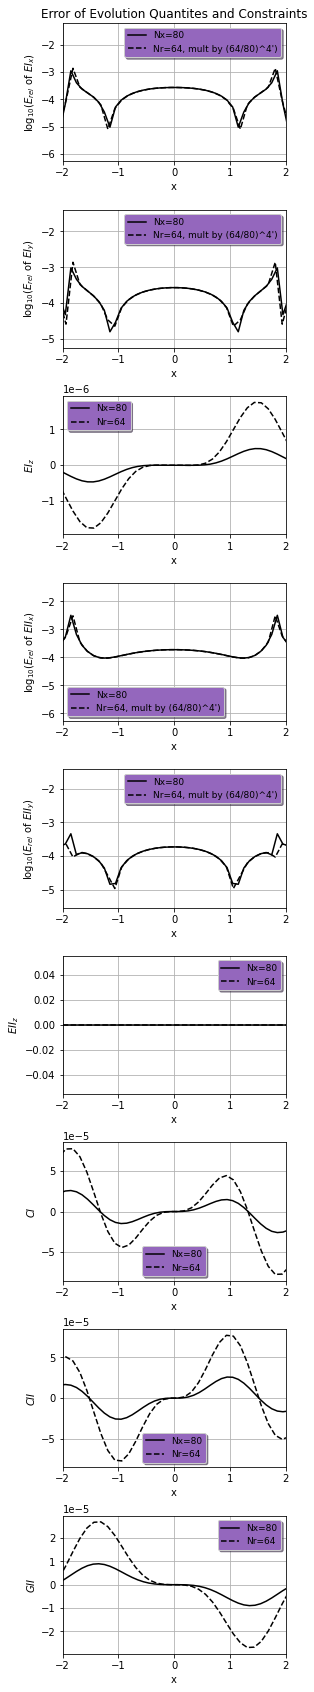

In [15]:
plotconvergence('out'+Nxx_L+'_1.250000.txt', 'out'+Nxx_H+'_1.250000.txt')

<a id='div_e'></a>

# Step 7: Comparison Divergence Constrain Violation  \[Back to [top](#toc)\]
$$\label{div_e}$$

Here we calculate the violation quantity

$$
\mathcal{C} \equiv \partial^i E_i,
$$

at each point on our grid (excluding the ghost zones) then calculate the L2 norm over the entire volume via

$$
\vert\vert C \vert\vert \equiv \left( \int_\mathcal{V} C^2 d\mathcal{V} \right)^{1/2}.
$$

We then compare our $\vert\vert C \vert\vert$ to that of [Knapp, Walker & Baumgarte (2002)](https://arxiv.org/abs/gr-qc/0201051). Thus, we confirm that our code replicates the qualitative behavior shown in figure 1 [Knapp, Walker & Baumgarte (2002)](https://arxiv.org/abs/gr-qc/0201051) for Systems I and II. And indeed, we observe static constraint violating nodes in System I (ADM - like) and their propgation in System II (BSSN - like).

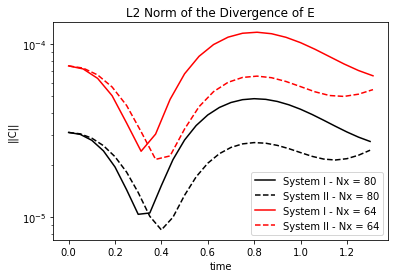

In [16]:
# Plotting the constraint violation
nrpy_divH = np.loadtxt(os.path.join(outdir,'out-highresolution.txt')).T

plt.plot(nrpy_divH[0], nrpy_divH[1], 'k-',label = 'System I - Nx = '+Nxx_H)

plt.plot(nrpy_divH[0], nrpy_divH[2], 'k--',label='System II - Nx = '+Nxx_H)

nrpy_divL = np.loadtxt(os.path.join(outdir,'out-lowresolution.txt')).T

plt.plot(nrpy_divL[0], nrpy_divL[1], 'r-',label = 'System I - Nx = '+Nxx_L)

plt.plot(nrpy_divL[0], nrpy_divL[2], 'r--',label='System II - Nx = '+Nxx_L)


plt.yscale('log')
plt.xlabel('time')
plt.ylabel('||C||')
# plt.xlim(0,2.2)
# plt.ylim(1e-4, 1e-5)
plt.title('L2 Norm of the Divergence of E')
plt.legend(loc='best')
plt.show()

<a id='latex_pdf_output'></a>

# Step 8: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-Cartesian.pdf](Tutorial-Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-Cartesian.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [17]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-Cartesian")

Created Tutorial-Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-
    Cartesian.tex, and compiled LaTeX file to PDF file Tutorial-
    Start_to_Finish-Solving_Maxwells_Equations_in_Vacuum-Cartesian.pdf
